<a href="https://colab.research.google.com/github/veruizr/ML_Doc/blob/main/kaggle_for_detailed_results.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#March Machine Learning Mania 2025
##Forecast the 2025 NCAA Basketball Tournaments

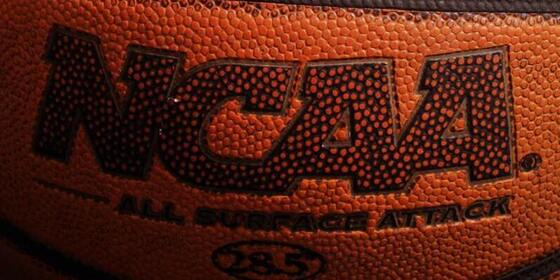

Para abordar el reto de Kaggle, se planteó una solución basada en los archivos de resultados detallados por temporada tanto en masculino (MNCAA), como en femenino (WNCAA) y se consultaron resultados históricos de los torneos para los dos torneos. Se utilizó un modelo de predicciones basado en Random Forest, pero que se fortaleció con modelos adicionales presentes en la libreria Scikit learn.

###XGBoost (eXtreme Gradient Boosting)

Es un modelo de aumento de gradiente  muy utilizado en predicciones con grandes volúmenes de datos para identificar patrones complejos y generar estadisticas relacionadas. Tiene 3 aspectos importantes:

*Aumento de Gradiente Secuencial*: Entrena árboles de manera secuencial, donde cada árbol corrige los errores del anterior

Aprender relaciones complicadas entre estadísticas (por ejemplo: cómo se combinan la defensa y el ataque).

Funciona bien incluso si faltan algunos datos.

Evita errores por sobreajuste gracias a técnicas que penalizan modelos demasiado complejos.

### LightGBM (Light Gradient Boosting Machine)

Es muy parecido a XGBoost, pero más rápido y más ligero.
tiene 3 aspectos clave:

Agrupa valores similares para simplificar los cálculos.

Construye los árboles yendo directamente a las ramas más prometedoras (no paso a paso).

Se enfoca en ejemplos donde el error es más alto, para aprender mejor.


1. Cargar librerías

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import log_loss, accuracy_score
import xgboost as xgb
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')

print("Librerías importadas correctamente")


Librerías importadas correctamente


2. Cargar archivos csv disponibles. se trabajó con los resultados detallados de los torneos femenino y masculino y con los resultados de torneos anteriores

In [ ]:
# Cargar todos los archivos necesarios
print("Cargando datos...")

# Datos de resultados detallados
men_detailed = pd.read_csv('MRegularSeasonDetailedResults.csv')
women_detailed = pd.read_csv('WRegularSeasonDetailedResults.csv')

# Datos de torneos pasados para entrenamiento
men_tourney = pd.read_csv('MNCAATourneyDetailedResults.csv')
women_tourney = pd.read_csv('WNCAATourneyDetailedResults.csv')

# Archivo de submission para Stage 2
sample_sub = pd.read_csv('SampleSubmissionStage2.csv')

# Verificar datos cargados
print(f"Datos masculinos temporada regular: {len(men_detailed)} partidos")
print(f"Datos femeninos temporada regular: {len(women_detailed)} partidos")
print(f"Predicciones Stage 2: {len(sample_sub)} enfrentamientos")

# Verificar que son predicciones para 2025
ids_2025 = sample_sub[sample_sub['ID'].str.startswith('2025_')]
print(f"Predicciones para 2025: {len(ids_2025)}")


Cargando datos...
Datos masculinos temporada regular: 118882 partidos
Datos femeninos temporada regular: 81708 partidos
Predicciones Stage 2: 131407 enfrentamientos
Predicciones para 2025: 131407


3. Crear estadisticas detalladas

In [ ]:
def calculate_team_stats_simple(detailed_results):
    """
    Función simplificada y robusta para calcular estadísticas de equipos
    """
    if detailed_results is None or len(detailed_results) == 0:
        print(" No hay datos para procesar")
        return None

    print(f"Procesando {len(detailed_results)} partidos...")

    # Verificar columnas disponibles
    print(f"Columnas disponibles: {detailed_results.columns.tolist()[:10]}...")

    all_team_games = []

    # Procesar cada partido
    for idx, game in detailed_results.iterrows():
        if idx % 1000 == 0:
            print(f"  Procesado {idx}/{len(detailed_results)} partidos")

        try:
            # Datos del equipo ganador
            winner_game = {
                'Season': game['Season'],
                'TeamID': game['WTeamID'],
                'Score': game['WScore'],
                'OppScore': game['LScore'],
                'Result': 1
            }

            # Agregar estadísticas detalladas si están disponibles
            if 'WFGM' in game:
                winner_game.update({
                    'FGM': game['WFGM'],
                    'FGA': game['WFGA'],
                    'FGM3': game.get('WFGM3', 0),
                    'FGA3': game.get('WFGA3', 0),
                    'FTM': game.get('WFTM', 0),
                    'FTA': game.get('WFTA', 0),
                    'OR': game.get('WOR', 0),
                    'DR': game.get('WDR', 0),
                    'Ast': game.get('WAst', 0),
                    'TO': game.get('WTO', 0),
                    'Stl': game.get('WStl', 0),
                    'Blk': game.get('WBlk', 0),
                    'PF': game.get('WPF', 0)
                })

            all_team_games.append(winner_game)

            # Datos del equipo perdedor
            loser_game = {
                'Season': game['Season'],
                'TeamID': game['LTeamID'],
                'Score': game['LScore'],
                'OppScore': game['WScore'],
                'Result': 0
            }

            # Agregar estadísticas detalladas si están disponibles
            if 'LFGM' in game:
                loser_game.update({
                    'FGM': game['LFGM'],
                    'FGA': game['LFGA'],
                    'FGM3': game.get('LFGM3', 0),
                    'FGA3': game.get('LFGA3', 0),
                    'FTM': game.get('LFTM', 0),
                    'FTA': game.get('LFTA', 0),
                    'OR': game.get('LOR', 0),
                    'DR': game.get('LDR', 0),
                    'Ast': game.get('LAst', 0),
                    'TO': game.get('LTO', 0),
                    'Stl': game.get('LStl', 0),
                    'Blk': game.get('LBlk', 0),
                    'PF': game.get('LPF', 0)
                })

            all_team_games.append(loser_game)

        except Exception as e:
            print(f"Error procesando partido {idx}: {e}")
            continue

    # Convertir a DataFrame
    all_games_df = pd.DataFrame(all_team_games)
    print(f" Creado DataFrame con {len(all_games_df)} registros de juegos individuales")

    # Calcular estadísticas por equipo y temporada
    print("Calculando estadísticas agregadas...")

    # Estadísticas básicas siempre disponibles
    basic_agg = {
        'Score': ['sum', 'mean', 'std'],
        'OppScore': ['sum', 'mean'],
        'Result': ['sum', 'count']
    }

    # Agregar estadísticas avanzadas si están disponibles
    if 'FGM' in all_games_df.columns:
        advanced_stats = {
            'FGM': ['sum'],
            'FGA': ['sum'],
            'FGM3': ['sum'],
            'FGA3': ['sum'],
            'FTM': ['sum'],
            'FTA': ['sum'],
            'OR': ['sum'],
            'DR': ['sum'],
            'Ast': ['sum'],
            'TO': ['sum']
        }
        basic_agg.update(advanced_stats)

    # Agrupar por equipo y temporada
    team_stats = all_games_df.groupby(['Season', 'TeamID']).agg(basic_agg).reset_index()

    # Aplanar nombres de columnas
    team_stats.columns = ['_'.join(col).strip() if col[1] else col[0] for col in team_stats.columns.values]

    # Calcular métricas derivadas
    team_stats['Games'] = team_stats['Result_count']
    team_stats['Wins'] = team_stats['Result_sum']
    team_stats['WinPct'] = team_stats['Wins'] / team_stats['Games']

    # Eficiencia básica
    team_stats['OffEff'] = team_stats['Score_mean']
    team_stats['DefEff'] = team_stats['OppScore_mean']

    # Estadísticas avanzadas si están disponibles
    if 'FGM_sum' in team_stats.columns:
        team_stats['FG_Pct'] = np.where(team_stats['FGA_sum'] > 0,
                                       team_stats['FGM_sum'] / team_stats['FGA_sum'], 0.45)
        team_stats['FG3_Pct'] = np.where(team_stats['FGA3_sum'] > 0,
                                        team_stats['FGM3_sum'] / team_stats['FGA3_sum'], 0.35)
        team_stats['FT_Pct'] = np.where(team_stats['FTA_sum'] > 0,
                                       team_stats['FTM_sum'] / team_stats['FTA_sum'], 0.75)
        team_stats['RebPerGame'] = (team_stats['OR_sum'] + team_stats['DR_sum']) / team_stats['Games']
        team_stats['AstPerGame'] = team_stats['Ast_sum'] / team_stats['Games']
        team_stats['AstTO_Ratio'] = np.where(team_stats['TO_sum'] > 0,
                                            team_stats['Ast_sum'] / team_stats['TO_sum'], 1.2)
    else:
        # Valores por defecto si no hay estadísticas detalladas
        team_stats['FG_Pct'] = 0.45
        team_stats['FG3_Pct'] = 0.35
        team_stats['FT_Pct'] = 0.75
        team_stats['RebPerGame'] = 35
        team_stats['AstPerGame'] = 15
        team_stats['AstTO_Ratio'] = 1.2

    # Limpiar datos
    team_stats = team_stats.fillna(0)
    team_stats = team_stats.replace([np.inf, -np.inf], 0)

    print(f"Estadísticas calculadas para {len(team_stats)} equipos-temporadas")
    return team_stats


In [ ]:
print("=== CALCULANDO ESTADÍSTICAS FALTANTES ===")

# Calcular estadísticas masculinas
try:
    print("Calculando estadísticas masculinas...")
    men_stats = calculate_team_stats_simple(men_detailed)
    if men_stats is not None:
        print(f"men_stats: {len(men_stats)} registros")
    else:
        print("Error calculando men_stats")
except Exception as e:
    print(f"Error en men_stats: {e}")
    men_stats = None

# Calcular estadísticas femeninas
try:
    print("Calculando estadísticas femeninas...")
    women_stats = calculate_team_stats_simple(women_detailed)
    if women_stats is not None:
        print(f"✅ women_stats: {len(women_stats)} registros")
    else:
        print("Error calculando women_stats")
except Exception as e:
    print(f"Error en women_stats: {e}")
    women_stats = None


=== CALCULANDO ESTADÍSTICAS FALTANTES ===
🏀 Calculando estadísticas masculinas...
📊 Procesando 118882 partidos...
Columnas disponibles: ['Season', 'DayNum', 'WTeamID', 'WScore', 'LTeamID', 'LScore', 'WLoc', 'NumOT', 'WFGM', 'WFGA']...
  Procesado 0/118882 partidos
  Procesado 1000/118882 partidos
  Procesado 2000/118882 partidos
  Procesado 3000/118882 partidos
  Procesado 4000/118882 partidos
  Procesado 5000/118882 partidos
  Procesado 6000/118882 partidos
  Procesado 7000/118882 partidos
  Procesado 8000/118882 partidos
  Procesado 9000/118882 partidos
  Procesado 10000/118882 partidos
  Procesado 11000/118882 partidos
  Procesado 12000/118882 partidos
  Procesado 13000/118882 partidos
  Procesado 14000/118882 partidos
  Procesado 15000/118882 partidos
  Procesado 16000/118882 partidos
  Procesado 17000/118882 partidos
  Procesado 18000/118882 partidos
  Procesado 19000/118882 partidos
  Procesado 20000/118882 partidos
  Procesado 21000/118882 partidos
  Procesado 22000/118882 parti

Generación del dataset para entrenamiento a partir de las estadisticas creadas previamente

In [ ]:
def create_training_data(tourney_results, team_stats):
    """
    Crea dataset de entrenamiento combinando resultados de torneos con estadísticas
    """
    training_data = []

    for _, game in tourney_results.iterrows():
        season = game['Season']

        # Determinar equipo 1 y equipo 2 (menor ID = equipo 1)
        team1 = min(game['WTeamID'], game['LTeamID'])
        team2 = max(game['WTeamID'], game['LTeamID'])

        # Target: 1 si team1 ganó, 0 si team2 ganó
        target = 1 if game['WTeamID'] == team1 else 0

        # Buscar estadísticas de ambos equipos
        t1_stats = team_stats[(team_stats['Season'] == season) &
                             (team_stats['TeamID'] == team1)]
        t2_stats = team_stats[(team_stats['Season'] == season) &
                             (team_stats['TeamID'] == team2)]

        if len(t1_stats) == 0 or len(t2_stats) == 0:
            continue

        t1 = t1_stats.iloc[0]
        t2 = t2_stats.iloc[0]

        # Crear features
        features = {
            'Season': season,
            'Team1': team1,
            'Team2': team2,

            # Features básicas
            'T1_WinPct': t1['WinPct'],
            'T2_WinPct': t2['WinPct'],
            'T1_ScoreAvg': t1['Score_mean'],
            'T2_ScoreAvg': t2['Score_mean'],

            # Diferencias
            'Diff_WinPct': t1['WinPct'] - t2['WinPct'],
            'Diff_ScoreAvg': t1['Score_mean'] - t2['Score_mean'],

            # Porcentajes de tiro
            'T1_FG_Pct': t1['FG_Pct'],
            'T2_FG_Pct': t2['FG_Pct'],
            'T1_FG3_Pct': t1['FG3_Pct'],
            'T2_FG3_Pct': t2['FG3_Pct'],
            'Diff_FG_Pct': t1['FG_Pct'] - t2['FG_Pct'],
            'Diff_FG3_Pct': t1['FG3_Pct'] - t2['FG3_Pct'],

            # Rebotes y asistencias
            'T1_RebPerGame': t1['RebPerGame'],
            'T2_RebPerGame': t2['RebPerGame'],
            'T1_AstPerGame': t1['AstPerGame'],
            'T2_AstPerGame': t2['AstPerGame'],
            'Diff_RebPerGame': t1['RebPerGame'] - t2['RebPerGame'],
            'Diff_AstPerGame': t1['AstPerGame'] - t2['AstPerGame'],

            # Ratio asistencias/pérdidas
            'T1_AstTO': t1['AstTO_Ratio'],
            'T2_AstTO': t2['AstTO_Ratio'],
            'Diff_AstTO': t1['AstTO_Ratio'] - t2['AstTO_Ratio'],

            # Target
            'Target': target
        }

        training_data.append(features)

    return pd.DataFrame(training_data)

# Crear datasets de entrenamiento
print("Creando datasets de entrenamiento...")
men_train = create_training_data(men_tourney, men_stats)
women_train = create_training_data(women_tourney, women_stats)

# Combinar ambos datasets
train_df = pd.concat([men_train, women_train], ignore_index=True)
print(f"Dataset de entrenamiento creado: {len(train_df)} partidos")


Creando datasets de entrenamiento...
Dataset de entrenamiento creado: 2276 partidos


5. Ensamble de modelos, se utiliza random forest y se complementa con métodos de clasificación XGB y LGBM

In [ ]:
class MarchMadnessEnsemble:
    def __init__(self):
        self.models = {
            'xgb': xgb.XGBClassifier(
                n_estimators=200,
                max_depth=6,
                learning_rate=0.1,
                random_state=42
            ),
            'lgb': lgb.LGBMClassifier(
                n_estimators=200,
                max_depth=6,
                learning_rate=0.1,
                random_state=42,
                verbose=-1
            ),
            'rf': RandomForestClassifier(
                n_estimators=200,
                max_depth=10,
                random_state=42
            )
        }
        self.scaler = StandardScaler()
        self.weights = [0.4, 0.4, 0.2]  # Pesos para XGB, LGB, RF

    def fit(self, X, y):
        print("Entrenando ensemble de modelos...")

        # Entrenar cada modelo
        for name, model in self.models.items():
            print(f"  Entrenando {name}...")
            model.fit(X, y)

        print("Ensemble entrenado exitosamente")
        return self

    def predict_proba(self, X):
        predictions = []

        for name, model in self.models.items():
            pred = model.predict_proba(X)[:, 1]
            predictions.append(pred)

        # Promedio ponderado
        ensemble_pred = np.average(predictions, axis=0, weights=self.weights)
        return ensemble_pred

# Preparar datos para entrenamiento
feature_cols = [col for col in train_df.columns if col not in ['Target', 'Season', 'Team1', 'Team2']]
X = train_df[feature_cols]
y = train_df['Target']

print(f"Features utilizadas: {len(feature_cols)}")
print("Features:", feature_cols[:10], "..." if len(feature_cols) > 10 else "")

# Dividir datos
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenar modelo
ensemble = MarchMadnessEnsemble()
ensemble.fit(X_train, y_train)

# Evaluar
val_preds = ensemble.predict_proba(X_val)
val_acc = accuracy_score(y_val, (val_preds > 0.5).astype(int))
val_logloss = log_loss(y_val, val_preds)

print(f"\nResultados de validación:")
print(f"Accuracy: {val_acc:.4f}")
print(f"Log Loss: {val_logloss:.4f}")


Features utilizadas: 21
Features: ['T1_WinPct', 'T2_WinPct', 'T1_ScoreAvg', 'T2_ScoreAvg', 'Diff_WinPct', 'Diff_ScoreAvg', 'T1_FG_Pct', 'T2_FG_Pct', 'T1_FG3_Pct', 'T2_FG3_Pct'] ...
Entrenando ensemble de modelos...
  Entrenando xgb...
  Entrenando lgb...
  Entrenando rf...
Ensemble entrenado exitosamente

Resultados de validación:
Accuracy: 0.6491
Log Loss: 0.6427


6. Generación de predicciones para la temporada 2025 (Stage 2)

In [ ]:
def generate_stage2_predictions(sample_sub, men_stats, women_stats, ensemble, feature_cols):
    """
    Genera predicciones para Stage 2 del torneo 2025
    """
    predictions = []

    print("Generando predicciones para Stage 2...")

    for idx, id_str in enumerate(sample_sub['ID']):
        if idx % 100 == 0:
            print(f"  Procesado {idx}/{len(sample_sub)} predicciones")

        # Parsear ID
        season, team1, team2 = map(int, id_str.split('_'))

        # Determinar si es masculino o femenino
        # Equipos masculinos: IDs típicamente 1100-1500
        # Equipos femeninos: IDs típicamente 3000-3500
        if team1 >= 3000 or team2 >= 3000:
            team_stats = women_stats
        else:
            team_stats = men_stats

        # Buscar estadísticas más recientes (temporada 2024)
        t1_stats = team_stats[(team_stats['Season'] == 2024) &
                             (team_stats['TeamID'] == team1)]
        t2_stats = team_stats[(team_stats['Season'] == 2024) &
                             (team_stats['TeamID'] == team2)]

        if len(t1_stats) == 0 or len(t2_stats) == 0:
            # Si no hay datos, usar predicción neutral
            pred = 0.5
        else:
            t1 = t1_stats.iloc[0]
            t2 = t2_stats.iloc[0]

            # Crear features (mismo formato que entrenamiento)
            features = {
                'T1_WinPct': t1['WinPct'],
                'T2_WinPct': t2['WinPct'],
                'T1_ScoreAvg': t1['Score_mean'],
                'T2_ScoreAvg': t2['Score_mean'],
                'Diff_WinPct': t1['WinPct'] - t2['WinPct'],
                'Diff_ScoreAvg': t1['Score_mean'] - t2['Score_mean'],
                'T1_FG_Pct': t1['FG_Pct'],
                'T2_FG_Pct': t2['FG_Pct'],
                'T1_FG3_Pct': t1['FG3_Pct'],
                'T2_FG3_Pct': t2['FG3_Pct'],
                'Diff_FG_Pct': t1['FG_Pct'] - t2['FG_Pct'],
                'Diff_FG3_Pct': t1['FG3_Pct'] - t2['FG3_Pct'],
                'T1_RebPerGame': t1['RebPerGame'],
                'T2_RebPerGame': t2['RebPerGame'],
                'T1_AstPerGame': t1['AstPerGame'],
                'T2_AstPerGame': t2['AstPerGame'],
                'Diff_RebPerGame': t1['RebPerGame'] - t2['RebPerGame'],
                'Diff_AstPerGame': t1['AstPerGame'] - t2['AstPerGame'],
                'T1_AstTO': t1['AstTO_Ratio'],
                'T2_AstTO': t2['AstTO_Ratio'],
                'Diff_AstTO': t1['AstTO_Ratio'] - t2['AstTO_Ratio']
            }

            # Convertir a DataFrame y predecir
            X_test = pd.DataFrame([features])[feature_cols]
            pred = ensemble.predict_proba(X_test)[0]

        predictions.append(pred)

    return predictions

# Generar predicciones
predictions = generate_stage2_predictions(sample_sub, men_stats, women_stats, ensemble, feature_cols)

# Agregar predicciones al DataFrame
sample_sub['Pred'] = predictions

print(f"\nPredicciones generadas: {len(predictions)}")
print(f"Rango de predicciones: {min(predictions):.3f} - {max(predictions):.3f}")
print(f"Predicción promedio: {np.mean(predictions):.3f}")


Generando predicciones para Stage 2...
  Procesado 0/131407 predicciones
  Procesado 100/131407 predicciones
  Procesado 200/131407 predicciones
  Procesado 300/131407 predicciones
  Procesado 400/131407 predicciones
  Procesado 500/131407 predicciones
  Procesado 600/131407 predicciones
  Procesado 700/131407 predicciones
  Procesado 800/131407 predicciones
  Procesado 900/131407 predicciones
  Procesado 1000/131407 predicciones
  Procesado 1100/131407 predicciones
  Procesado 1200/131407 predicciones
  Procesado 1300/131407 predicciones
  Procesado 1400/131407 predicciones
  Procesado 1500/131407 predicciones
  Procesado 1600/131407 predicciones
  Procesado 1700/131407 predicciones
  Procesado 1800/131407 predicciones
  Procesado 1900/131407 predicciones
  Procesado 2000/131407 predicciones
  Procesado 2100/131407 predicciones
  Procesado 2200/131407 predicciones
  Procesado 2300/131407 predicciones
  Procesado 2400/131407 predicciones
  Procesado 2500/131407 predicciones
  Procesado

creando el archivo del envio para cargar en la competencia

In [ ]:
# Verificar formato final
print("\nVerificando formato de submission:")
print(f"Columnas: {sample_sub.columns.tolist()}")
print(f"Primeras 5 filas:")
print(sample_sub.head())

# Guardar archivo final
output_file = '2025_final_submission.csv'
sample_sub[['ID', 'Pred']].to_csv(output_file, index=False)

print(f"\n Archivo de submission guardado: {output_file}")
print(f" Total de predicciones: {len(sample_sub)}")


# Estadísticas finales
print(f"\n Estadísticas de predicciones:")
print(f"Mínimo: {sample_sub['Pred'].min():.4f}")
print(f"Máximo: {sample_sub['Pred'].max():.4f}")
print(f"Promedio: {sample_sub['Pred'].mean():.4f}")
print(f"Mediana: {sample_sub['Pred'].median():.4f}")



Verificando formato de submission:
Columnas: ['ID', 'Pred']
Primeras 5 filas:
               ID      Pred
0  2025_1101_1102  0.266200
1  2025_1101_1103  0.287711
2  2025_1101_1104  0.049548
3  2025_1101_1105  0.689764
4  2025_1101_1106  0.360973

 Archivo de submission guardado: 2025_final_submission.csv
 Total de predicciones: 131407

 Estadísticas de predicciones:
Mínimo: 0.0011
Máximo: 0.9889
Promedio: 0.5574
Mediana: 0.6030
